[*********************100%***********************]  3 of 3 completed


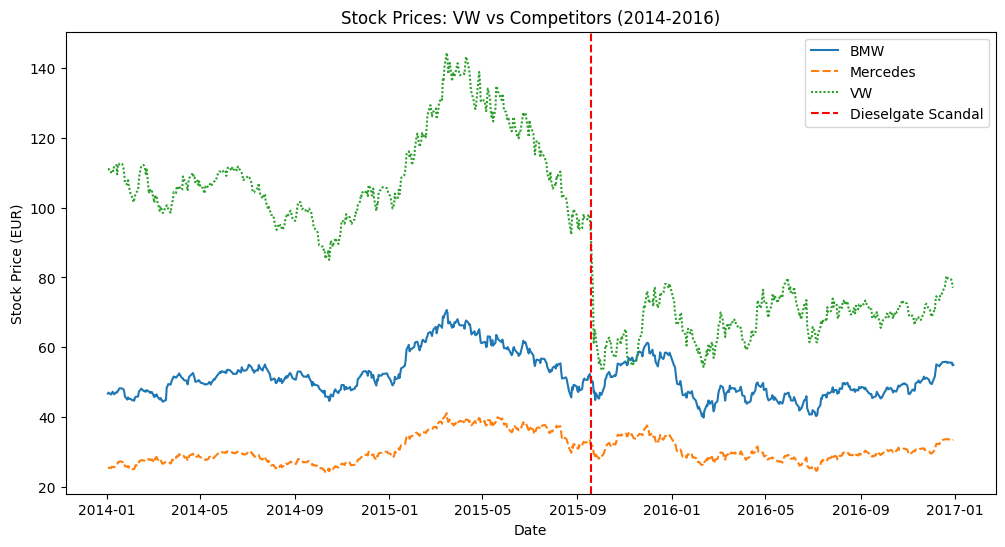


--- Correlation Matrix (Pre-Scandal) ---
               BMW  Mercedes        VW
BMW       1.000000   0.88664  0.890093
Mercedes  0.886640   1.00000  0.852760
VW        0.890093   0.85276  1.000000


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression

# 1. Configuration
# 'VOW3.DE' is Volkswagen (Germany)
# 'BMW.DE' and 'MBG.DE' (Mercedes-Benz) are controls
tickers = ['VOW3.DE', 'BMW.DE', 'MBG.DE']
start_date = '2014-01-01'
end_date = '2016-12-31'
scandal_date = '2015-09-18' # The day the EPA notice was public

# 2. Download Data
print("Downloading market data...")
data = yf.download(tickers, start=start_date, end=end_date)['Close'] # Changed 'Adj Close' to 'Close'

# 3. Rename columns for clarity
data.columns = ['BMW', 'Mercedes', 'VW']
data = data.dropna()

# 4. Visualize the "Shock"
plt.figure(figsize=(12, 6))
sns.lineplot(data=data)
plt.axvline(pd.to_datetime(scandal_date), color='red', linestyle='--', label='Dieselgate Scandal')
plt.title("Stock Prices: VW vs Competitors (2014-2016)")
plt.ylabel("Stock Price (EUR)")
plt.legend()
plt.show()

# 5. Calculate Correlation (Pre-Scandal)
# We need to prove that BMW/Mercedes are actually good predictors of VW *before* the scandal.
pre_scandal = data[data.index < scandal_date]
print("\n--- Correlation Matrix (Pre-Scandal) ---")
print(pre_scandal.corr())

**Insights**:
- The Plot: You should see all three stocks moving roughly together until the Red Line. After the line, VW should tank while the others stay relatively stable.

- The Correlation: You need high correlation (> 0.8) between VW and the others before the scandal. This justifies using BMW/Mercedes to model the "Counterfactual VW."

Model Intercept: 11.96
Model Coefficients (BMW, Mercedes): [1.34064302 0.8322988 ]


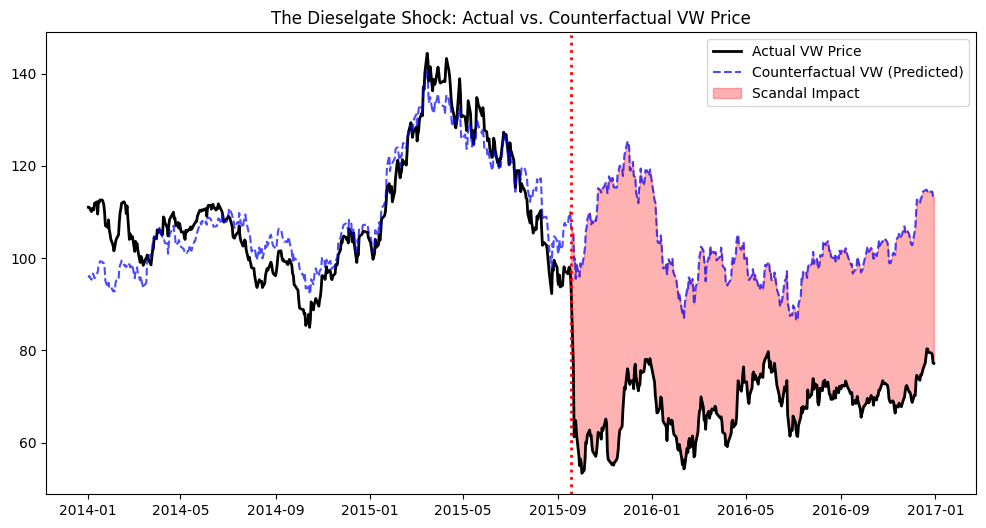

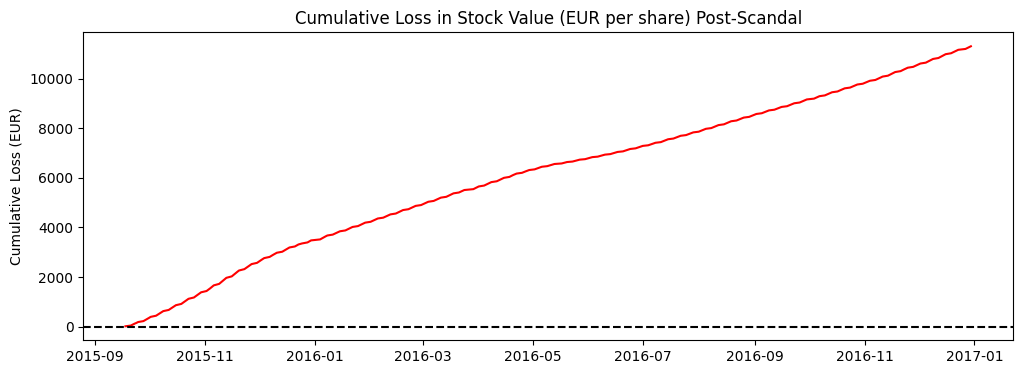

Total Value Lost per Share (End of 2016): €11304.65


In [ ]:
# 1. Split Data into Pre-Scandal (Training) and Post-Scandal (Testing)
train_data = data[data.index < scandal_date]
test_data = data[data.index >= scandal_date]

# Define Predictors (X) and Target (y)
feature_cols = ['BMW', 'Mercedes']
target_col = 'VW'

X_train = train_data[feature_cols]
y_train = train_data[target_col]

X_test = test_data[feature_cols]
y_test = test_data[target_col]

# 2. Train the Counterfactual Model
# We learn the "normal" relationship between competitors and VW
model = LinearRegression()
model.fit(X_train, y_train)

print(f"Model Intercept: {model.intercept_:.2f}")
print(f"Model Coefficients (BMW, Mercedes): {model.coef_}")

# 3. Predict the "Counterfactual" (What SHOULD have happened)
# We predict for the WHOLE timeline to see the fit before and after
X_all = data[feature_cols]
data['VW_Counterfactual'] = model.predict(X_all)

# 4. Calculate the "Causal Impact" (The difference)
# Impact = Predicted (No Scandal) - Actual (Scandal)
data['Impact'] = data['VW_Counterfactual'] - data['VW']

# 5. Visualize the Divergence
plt.figure(figsize=(12, 6))

# Plot Actual VW Price
plt.plot(data.index, data['VW'], label='Actual VW Price', color='black', linewidth=2)

# Plot Counterfactual (Synthetic) VW Price
plt.plot(data.index, data['VW_Counterfactual'], label='Counterfactual VW (Predicted)', color='blue', linestyle='--', alpha=0.7)

# Shade the area of impact
plt.fill_between(data.index, data['VW'], data['VW_Counterfactual'], 
                 where=(data.index >= scandal_date), color='red', alpha=0.3, label='Scandal Impact')

plt.axvline(pd.to_datetime(scandal_date), color='red', linestyle=':', linewidth=2)
plt.title("The Dieselgate Shock: Actual vs. Counterfactual VW Price")
plt.legend()

# save plot to reports
plt.savefig("reports/figures/dieselgate_impact.png")
plt.show()

# 6. Quantify the Total Loss (Cumulative Sum)
# We only care about the sum of losses AFTER the scandal date
post_scandal_impact = data[data.index >= scandal_date]['Impact']
cumulative_loss = post_scandal_impact.cumsum()

plt.figure(figsize=(12, 4))
plt.plot(cumulative_loss.index, cumulative_loss, color='red')
plt.title("Cumulative Loss in Stock Value (EUR per share) Post-Scandal")
plt.ylabel("Cumulative Loss (EUR)")
plt.axhline(0, color='black', linestyle='--')

# save plot to reports
plt.savefig("reports/figures/dieselgate_cumulative_loss.png")

plt.show()

print(f"Total Value Lost per Share (End of 2016): €{cumulative_loss.iloc[-1]:.2f}")